In [1]:
from xml.etree import ElementTree
import pandas as pd
import os
import numpy as np
import cv2
path = os.getcwd()
path

'/home/raju/Desktop/datasets/Driving_in_the_matrix'

In [2]:
def get_file_lines(file_path):
    """ Function that read a file and return a list of line.
    Function that read a file and return a list of line. Test it to be\
     the fastest way to read lines from a file.
    Args:
        file_path (str): file path to be readed
    Returns:
        (:obj:`list` of :obj:`str`): lines readed from file
    """
    with open(file_path, 'r') as file:
        return file.read().splitlines()

In [3]:
class VocAnnotaionParser(object):
    def __init__(self, image_path = path + '/VOC2012/JPEGImages',
                image_set_path=path+'/VOC2012/ImageSets/Main/trainval.txt',
                annotation_path=path+'/VOC2012/Annotations'):
        self.image_path = image_path
        self.image_set_path = image_set_path
        self.annotation_path = annotation_path
        
        self._annotation_line_list = [] # a list of annotations, each annotation is ict
        self._parse_from_voc2012() # parse all data
        
    @property
    def annotation_line_list(self):
        return self._annotation_line_list
    
    def get_annotation_dataframe(self):
        return pd.DataFrame(self.annotation_line_list)
        
    def _parse_from_voc2012(self):
        
        filenames_list = get_file_lines(self.image_set_path)
        #print(filenames_list)
        for filename in filenames_list:
            annotation_file = self._get_img_detection_filepath(self.annotation_path, filename)
            # Tree of the XML
            tree = ElementTree.parse(annotation_file)
            #print(tree)
            root_node = tree.getroot()
            #print(root_node)
            img_filename = root_node.find('filename').text
            #print(img_filename)
            img_full_path = self._get_img_filepath(filename + '.jpg')
            # get the size of the image from the annotation xml file
            width, height = self._get_img_size(root_node)
            #print(width, height)
            #get the the list of all object trees from the annotation xml
            object_tree_list = root_node.findall('object')
            #print(object_tree_list)
            
            #for each object tree
            for object_annotation in object_tree_list:
                # create a dictionary with all the information
                # {img,img_full_path,width,height,class_name,xmin,ymin,xmax,ymax}
                row_dictionary = {}

                class_name = self._get_annotation_classname(object_annotation)
                obj_bbox = object_annotation.find('bndbox')
                xmin, ymin, xmax, ymax = self._get_annotation_bbox(obj_bbox)

                # now that we have all the information from an annotation bbox
                # create a dict to be inserted in the final result
                row_dictionary.update({'filename': filename,
                                       'img_full_path': img_full_path,
                                       'width': width,
                                       'height': height,
                                       'class_name': class_name,
                                       'xmin': xmin,
                                       'ymin': ymin,
                                       'xmax': xmax,
                                       'ymax': ymax})
                self._annotation_line_list.append(row_dictionary)
            
    
    
    def _get_img_detection_filepath(self, voc_annotations_path, img_name):
        return os.path.join(voc_annotations_path, img_name + '.xml')
        
    def _get_img_filepath(self, image):
        return os.path.join(self.image_path, image)
    
    def _get_img_size(self, root_node):
        size_tree = root_node.find('size')
        width = float(size_tree.find('width').text)
        height = float(size_tree.find('height').text)
        return (width, height)
    
    def _get_annotation_classname(self, object_annotation):
        return object_annotation.find('name').text

    def _get_annotation_bbox(self, bbox_node):
        xmin = int(round(float(bbox_node.find('xmin').text)))
        ymin = int(round(float(bbox_node.find('ymin').text)))
        xmax = int(round(float(bbox_node.find('xmax').text)))
        ymax = int(round(float(bbox_node.find('ymax').text)))
        return (xmin, ymin, xmax, ymax)

In [4]:
parser = VocAnnotaionParser()
df = parser.get_annotation_dataframe()

In [5]:
df.shape

(58701, 9)

In [6]:
df.shape[0]

58701

In [7]:
df.head()

,class_name,filename,height,img_full_path,width,xmax,xmin,ymax,ymin
0,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,806,744,420,368
1,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,1425,1358,419,406
2,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,42,1,448,384
3,car,3402109,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,1425,1358,419,406
4,car,3402109,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,806,744,420,368


In [8]:
df.dtypes

class_name        object
filename          object
height           float64
img_full_path     object
width            float64
xmax               int64
xmin               int64
ymax               int64
ymin               int64
dtype: object

In [9]:
df['class_name'].value_counts()

car          57776
motorbike      921
person           4
Name: class_name, dtype: int64

In [10]:
df['class_name'] = df['class_name'].astype('category')
df.dtypes

class_name       category
filename           object
height            float64
img_full_path      object
width             float64
xmax                int64
xmin                int64
ymax                int64
ymin                int64
dtype: object

In [47]:
count = 0
for i in range(df.shape[0]):
    images = df['img_full_path'][i]
    img = cv2.imread(images)
    
    xmin = int(float(df['xmin'][i]))
    xmax = int(float(df['xmax'][i]))
    ymin = int(float(df['ymin'][i]))
    ymax = int(float(df['ymax'][i]))
    
    crop = img[int(ymin): int(ymax), int(xmin):int(xmax)]
    
    filename = df['filename'][i] 
    crop = cv2.resize(crop, dsize=(224,224))
    
    #cropped_image = cv2.imread(crop)
    #image_array = np.array(cropped_image)
    
    #np.save('./VOC2012/image_array' + filename + '_'+ '.npy', image_array)
      
    cv2.imwrite('./VOC2012/cropped_images/' + filename + '_' + str(i) +'.jpg', crop)
    

KeyboardInterrupt: 

In [10]:
import glob

cropped_images = glob.glob('/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/*.jpg')
cropped_images

['/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3389410_39666.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3386120_55249.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3389052_41878.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3400655_6474.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3398359_17523.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3387757_47413.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3398816_15544.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3385806_56115.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3399802_10766.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3389268_40681.jpg',
 '/home/raju/Desktop/datasets/Driving_in_the_matrix

In [11]:
df['Cropped_images_path'] = pd.Series(cropped_images, index = df.index)

In [12]:
df.head(5)

,class_name,filename,height,img_full_path,width,xmax,xmin,ymax,ymin,Cropped_images_path
0,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,806,744,420,368,/home/raju/Desktop/datasets/Driving_in_the_mat...
1,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,1425,1358,419,406,/home/raju/Desktop/datasets/Driving_in_the_mat...
2,car,3402114,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,42,1,448,384,/home/raju/Desktop/datasets/Driving_in_the_mat...
3,car,3402109,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,1425,1358,419,406,/home/raju/Desktop/datasets/Driving_in_the_mat...
4,car,3402109,1052.0,/home/raju/Desktop/datasets/Driving_in_the_mat...,1914.0,806,744,420,368,/home/raju/Desktop/datasets/Driving_in_the_mat...


In [13]:
df.shape

(58701, 10)

In [14]:
labels = df['class_name'][0:10000]
labels = pd.get_dummies(labels)
Y = np.array(labels)
Y.shape

(10000, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58701 entries, 0 to 58700
Data columns (total 10 columns):
class_name             58701 non-null object
filename               58701 non-null object
height                 58701 non-null float64
img_full_path          58701 non-null object
width                  58701 non-null float64
xmax                   58701 non-null int64
xmin                   58701 non-null int64
ymax                   58701 non-null int64
ymin                   58701 non-null int64
Cropped_images_path    58701 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 4.5+ MB


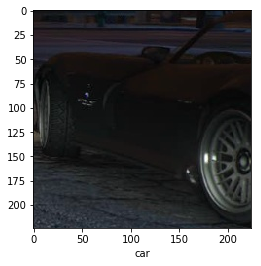

In [54]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

im = cv2.imread(df['Cropped_images_path'][8])
plt.imshow(im)
plt.xlabel(df['class_name'][8])
plt.show()

## Keras VGG16

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.initializers import he_normal
from keras.initializers import Zeros
from keras.activations import relu
from keras.layers import Flatten
from keras.activations import softmax
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.metrics import top_k_categorical_accuracy

from keras.applications import VGG16, VGG19

import os
import cv2
import numpy as np

Using TensorFlow backend.


In [17]:
df['Cropped_images_path'][9]

'/home/raju/Desktop/datasets/Driving_in_the_matrix/VOC2012/cropped_images/3389268_40681.jpg'

In [22]:
Y = np.array(labels)
np.save('/home/raju/Desktop/labels',Y)

In [23]:
Classes = np.load('/home/raju/Desktop/labels.npy')
Classes.shape

(10000, 2)

In [21]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [22]:
X = []
count = 0
for i in range(len(df['xmin'][0:10000])):
    img = load_img(df['Cropped_images_path'][i])
    img_array = img_to_array(img)
    X.append(img_array)
    
    count += 1
    
    if i%250 ==0:
        print('%d images to array'%i)


0 images to array
250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
5250 images to array
5500 images to array
5750 images to array
6000 images to array
6250 images to array
6500 images to array
6750 images to array
7000 images to array
7250 images to array
7500 images to array
7750 images to array
8000 images to array
8250 images to array
8500 images to array
8750 images to array
9000 images to array
9250 images to array
9500 images to array
9750 images to array


In [ ]:
X = np.array(X)
np.save('/home/raju/Desktop/image_arry.npz', X)

In [32]:
from sklearn.model_selection import train_test_split

In [20]:
X = np.load('/home/raju/Desktop/image_array.npy')

In [21]:
X.shape

(10000, 224, 224, 3)